<a href="https://colab.research.google.com/github/Adhini99/Chest-X-Ray-Classification/blob/main/Copy_of_Chest_X_Ray_Classification_with_Dense_and_Swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
khanfashee_nih_chest_x_ray_14_224x224_resized_path = kagglehub.dataset_download('khanfashee/nih-chest-x-ray-14-224x224-resized')

print('Data source import complete.')


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
import torch
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import load_model
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model
from keras.optimizers import Adamax
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Multiply, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from pathlib import Path

from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [ ]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BASE_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224")
    DATA_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized")
    OUTPUT_PATH = Path("/kaggle/working")
    BEST_MODEL_PATH = "models/best_model.pt"

    EPOCHS = 5
    EPOCHS_PER_START = 5
    START_EPOCH = 0

    BATCH_SIZE = 64
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    COLOR_MODE = 'rgb'
    TARGET_SIZE = (224, 224)
    INTERVAL = 10

    CHECKPOINT_PATH_VAL_LOSS = 'model/DenseNet121_val_loss.keras'
    CHECKPOINT_PATH_VAL_AUC = 'model/DenseNet121_val_AUC.keras'
    CHECKPOINT_PATH_TRAIN_LOSS = 'model/DenseNet121_train_loss.keras'
    CHECKPOINT_PATH_TRAIN_AUC = 'model/DenseNet121_train_AUC.keras'
    CHECKPOINT_PATH_TRAIN_ACCURACY = 'model/DenseNet121_train_accuracy.keras'
    CHECKPOINT_PATH_VAL_ACCURACY = 'model/DenseNet121_val_accuracy.keras'
    CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH_VAL_LOSS)

os.makedirs(CFG.OUTPUT_PATH / "model", exist_ok=True)

In [ ]:
data_entry_df = pd.read_csv(f'{CFG.DATA_PATH}/Data_Entry_2017.csv')
bbox_df = pd.read_csv(f'{CFG.DATA_PATH}/BBox_List_2017_Official_NIH.csv')
with open(f'{CFG.DATA_PATH}/train_val_list_NIH.txt', 'r') as f:
    train_val_list = [line.strip() for line in f]
with open(f'{CFG.DATA_PATH}/test_list_NIH.txt', 'r') as f:
    test_list = [line.strip() for line in f]

train_val_df = data_entry_df[data_entry_df['Image Index'].isin(train_val_list)]
test_df = data_entry_df[data_entry_df['Image Index'].isin(test_list)]

train_val_df['full_path'] = train_val_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))
test_df['full_path'] = test_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))

In [ ]:
for cls in CFG.CLASS_NAMES:
    train_val_df[cls] = train_val_df['Finding Labels'].apply(lambda x: 1 if cls in x.split('|') else 0)
    test_df[cls] = test_df['Finding Labels'].apply(lambda x: 1 if cls in x.split('|') else 0)

train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42)

train_df = train_df[train_df['full_path'].apply(os.path.exists)]
val_df = val_df[val_df['full_path'].apply(os.path.exists)]
test_df = test_df[test_df['full_path'].apply(os.path.exists)]

train_df.to_csv(f'{CFG.OUTPUT_PATH}/train.csv', index=False)
val_df.to_csv(f'{CFG.OUTPUT_PATH}/validation.csv', index=False)
test_df.to_csv(f'{CFG.OUTPUT_PATH}/test.csv', index=False)

train_df = pd.read_csv(f'{CFG.OUTPUT_PATH}/train.csv')
val_df = pd.read_csv(f'{CFG.OUTPUT_PATH}/validation.csv')
test_df = pd.read_csv(f'{CFG.OUTPUT_PATH}/test.csv')

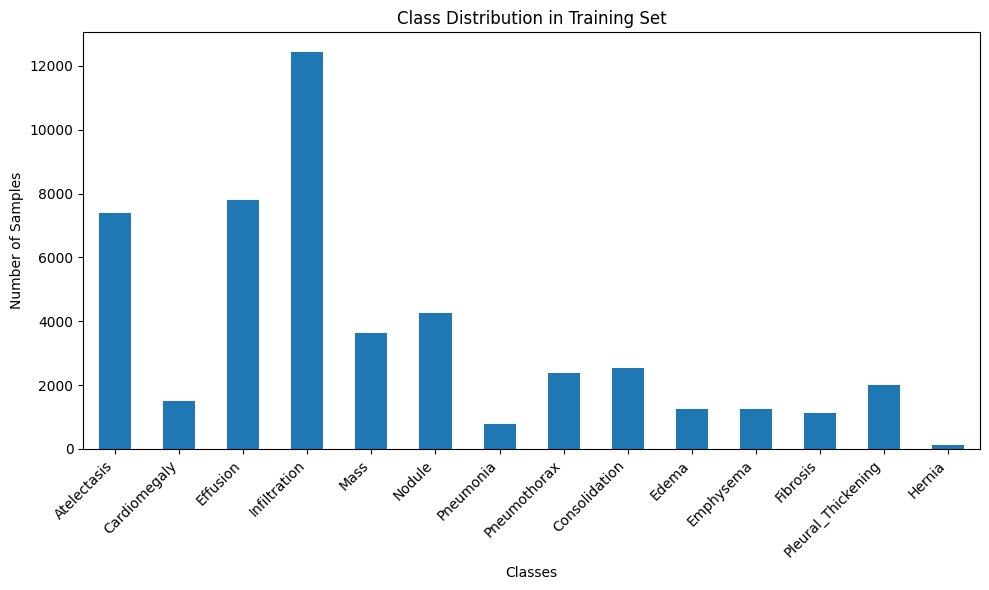

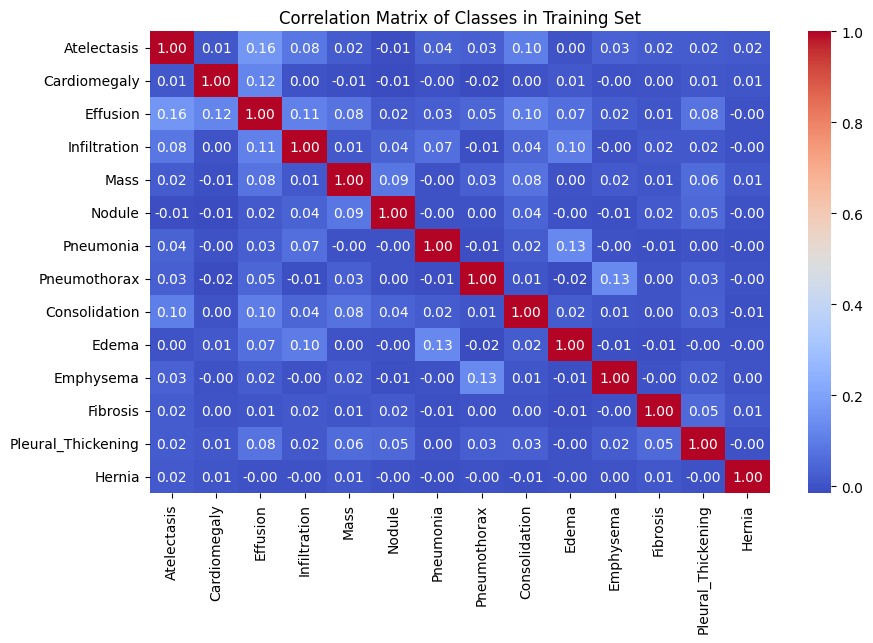

Found 77871 validated image filenames.
Found 8653 validated image filenames.
Found 25596 validated image filenames.


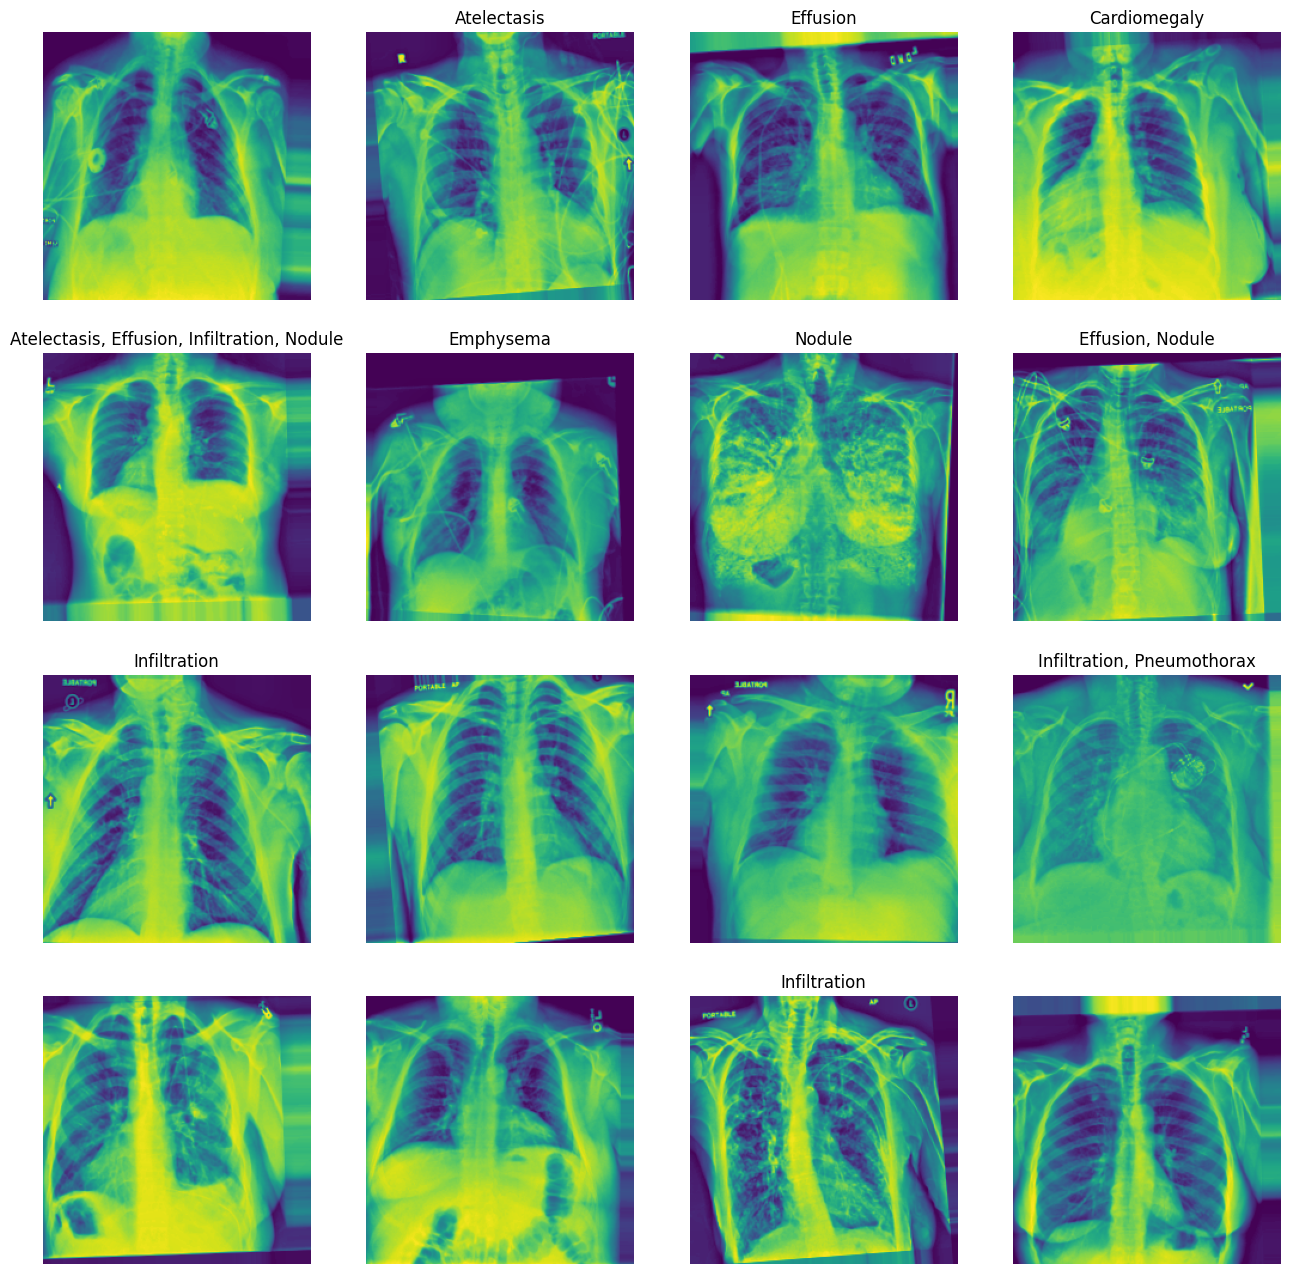

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(10, 6))
train_df[CFG.CLASS_NAMES].sum().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_distribution_train.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(train_df[CFG.CLASS_NAMES].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Classes in Training Set')
plt.savefig('class_correlation_train.png')
plt.show()

def apply_clahe(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    gray = np.uint8(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(gray)
    if len(image.shape) == 3:
        clahe_img = cv2.cvtColor(cl, cv2.COLOR_GRAY2RGB)
    else:
        clahe_img = cl
    return clahe_img

def preprocess_image(img):
    img = apply_clahe(img)
    img = img / 255.0
    img = (img - mean) / std
    return img

train_generator = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.05,
    rotation_range=5,
    shear_range=0.1,
    zoom_range=0.05,
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE
)

val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='full_path',
    y_col=CFG.CLASS_NAMES,
    target_size=CFG.TARGET_SIZE,
    color_mode=CFG.COLOR_MODE,
    class_mode='raw',
    batch_size=CFG.BATCH_SIZE,
    shuffle=False
)

images, labels_encoded = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for image, label_encoded, ax in zip(images, labels_encoded, axes.flatten()):
    ax.imshow(image[:, :, 0])
    predicted_classes = [
        class_name for class_name, class_score in zip(CFG.CLASS_NAMES, label_encoded)
        if class_score > 0.5
    ]
    ax.set_title(', '.join(predicted_classes))
    ax.axis('off')
plt.savefig('sample_images.png')
plt.show()

Train set size: 1209 images
Validation set size: 173 images
Test set size: 1349 images
Train class distribution:
Atelectasis           268
Cardiomegaly          114
Effusion              283
Infiltration          338
Mass                  182
Nodule                152
Pneumonia              96
Pneumothorax          124
Consolidation         150
Edema                 119
Emphysema             114
Fibrosis              108
Pleural_Thickening    148
Hernia                 94
dtype: int64
Epoch 1/5, DenseNet121 - Train Loss: 2.3661, Val Loss: 2.2937, Mean AUC: 0.5706
Epoch 2/5, DenseNet121 - Train Loss: 2.0880, Val Loss: 2.2350, Mean AUC: 0.6122
Epoch 3/5, DenseNet121 - Train Loss: 1.9705, Val Loss: 2.2685, Mean AUC: 0.6070
Epoch 4/5, DenseNet121 - Train Loss: 1.8612, Val Loss: 2.2487, Mean AUC: 0.6330
Epoch 5/5, DenseNet121 - Train Loss: 1.7549, Val Loss: 2.3215, Mean AUC: 0.6190
Epoch 1/5, SwinTransformer - Train Loss: 2.1962, Val Loss: 2.1927, Mean AUC: 0.5338
Epoch 2/5, SwinTransformer

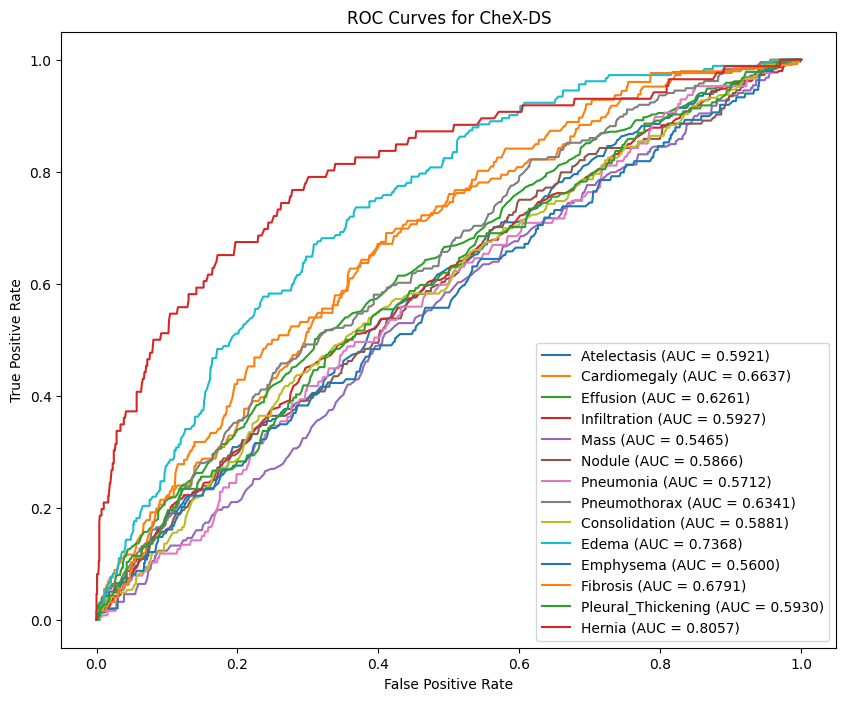

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from pathlib import Path
from scipy.optimize import differential_evolution, LinearConstraint
import timm
import warnings
warnings.filterwarnings("ignore")

# CFG class
class CFG:
    CLASS_NAMES = [
        "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration", "Mass",
        "Nodule", "Pneumonia", "Pneumothorax", "Consolidation", "Edema",
        "Emphysema", "Fibrosis", "Pleural_Thickening", "Hernia"
    ]
    BASE_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224")
    DATA_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized")
    OUTPUT_PATH = Path("/kaggle/working")
    BEST_MODEL_PATH = "models/best_model.pt"

    EPOCHS = 5
    BATCH_SIZE = 16
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    COLOR_MODE = 'rgb'
    TARGET_SIZE = (224, 224)

    CHECKPOINT_PATH_DENSENET = str(OUTPUT_PATH / 'model/DenseNet121_val_auc.pt')
    CHECKPOINT_PATH_SWIN = str(OUTPUT_PATH / 'model/SwinTransformer_val_auc.pt')
    CHECKPOINT_DIR = str(OUTPUT_PATH / 'model')

# Ensure output directories exist
os.makedirs(CFG.OUTPUT_PATH / "model", exist_ok=True)

# Data loading and preprocessing
data_entry_df = pd.read_csv(f'{CFG.DATA_PATH}/Data_Entry_2017.csv')
with open(f'{CFG.DATA_PATH}/train_val_list_NIH.txt', 'r') as f:
    train_val_list = [line.strip() for line in f]
with open(f'{CFG.DATA_PATH}/test_list_NIH.txt', 'r') as f:
    test_list = [line.strip() for line in f]

train_val_df = data_entry_df[data_entry_df['Image Index'].isin(train_val_list)]
test_df = data_entry_df[data_entry_df['Image Index'].isin(test_list)]

train_val_df['full_path'] = train_val_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))
test_df['full_path'] = test_df['Image Index'].apply(lambda x: str(CFG.BASE_PATH / x))

for cls in CFG.CLASS_NAMES:
    train_val_df[cls] = train_val_df['Finding Labels'].apply(lambda x: 1 if cls in x.split('|') else 0)
    test_df[cls] = test_df['Finding Labels'].apply(lambda x: 1 if cls in x.split('|') else 0)

# Select 100 images per class from train_val_df
sampled_dfs = []
for cls in CFG.CLASS_NAMES:
    class_df = train_val_df[train_val_df[cls] == 1]
    if len(class_df) >= 100:
        sampled_df = class_df.sample(n=100, random_state=42)
    else:
        sampled_df = class_df
    sampled_dfs.append(sampled_df)

train_val_df = pd.concat(sampled_dfs).drop_duplicates(subset='Image Index')
train_val_df = train_val_df[train_val_df['full_path'].apply(os.path.exists)]

# Split into train and validation
train_df, val_df = train_test_split(train_val_df, test_size=0.125, random_state=42)

# Sample test set to ~1,349 images
sampled_test_dfs = []
for cls in CFG.CLASS_NAMES:
    class_df = test_df[test_df[cls] == 1]
    if len(class_df) >= 100:
        sampled_df = class_df.sample(n=100, random_state=42)
    else:
        sampled_df = class_df
    sampled_test_dfs.append(sampled_df)
test_df = pd.concat(sampled_test_dfs).drop_duplicates(subset='Image Index')
test_df = test_df[test_df['full_path'].apply(os.path.exists)]

# Save filtered datasets
train_df.to_csv(f'{CFG.OUTPUT_PATH}/train_100_per_class.csv', index=False)
val_df.to_csv(f'{CFG.OUTPUT_PATH}/validation_100_per_class.csv', index=False)
test_df.to_csv(f'{CFG.OUTPUT_PATH}/test.csv', index=False)

# Print dataset sizes and class distribution
print(f"Train set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")
print(f"Test set size: {len(test_df)} images")
print("Train class distribution:")
print(train_df[CFG.CLASS_NAMES].sum())

# Custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_names = CFG.CLASS_NAMES

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['full_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = apply_clahe(image)
        image = (image / 255.0 - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        image = image.transpose((2, 0, 1))
        image = torch.tensor(image, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        labels = self.dataframe.iloc[idx][self.class_names].values.astype(np.float32)
        return image, torch.tensor(labels, dtype=torch.float32), img_path

# CLAHE function
def apply_clahe(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    gray = np.uint8(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(gray)
    if len(image.shape) == 3:
        clahe_img = cv2.cvtColor(cl, cv2.COLOR_GRAY2RGB)
    else:
        clahe_img = cl
    return clahe_img

# Data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.05), scale=(0.95, 1.05), shear=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Data loaders with drop_last=True for training
train_dataset = ChestXRayDataset(train_df, transform=train_transform)
val_dataset = ChestXRayDataset(val_df, transform=val_transform)
test_dataset = ChestXRayDataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)

# Compute class weights
def compute_class_weights(df, class_names):
    pos_ratios = df[class_names].mean()
    weights = torch.zeros(len(class_names))
    for i, cls in enumerate(class_names):
        rho = pos_ratios[cls]
        weights[i] = torch.exp(torch.tensor(1 - rho))
    return weights.to(CFG.DEVICE)

# Custom Loss Function
class CombinedLoss(nn.Module):
    def __init__(self, gamma1=1.0, gamma2=4.0, margin=0.05):
        super(CombinedLoss, self).__init__()
        self.gamma1 = gamma1
        self.gamma2 = gamma2
        self.margin = margin

    def forward(self, inputs, targets, weights):
        if inputs.shape != targets.shape:
            raise ValueError(f"Inputs shape {inputs.shape} does not match targets shape {targets.shape}")
        if inputs.shape[1] != len(CFG.CLASS_NAMES):
            raise ValueError(f"Expected {len(CFG.CLASS_NAMES)} classes, got {inputs.shape[1]}")
        inputs = torch.clamp(inputs, 0, 1)
        inputs_m = torch.clamp(inputs - self.margin, min=0)
        loss = -torch.sum(
            weights[None, :] * (
                (1 - inputs) ** self.gamma1 * targets * torch.log(inputs + 1e-10) +
                inputs_m ** self.gamma2 * (1 - targets) * torch.log(1 - inputs_m + 1e-10)
            ), dim=1
        )
        return loss.mean()

# DenseNet121 Model
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes=len(CFG.CLASS_NAMES)):
        super(DenseNet121Model, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_features=False):
        features = self.densenet.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.densenet.classifier(out)
        out = self.sigmoid(out)
        if return_features:
            return out, features
        return out

# Swin Transformer Model
class SwinTransformerModel(nn.Module):
    def __init__(self, num_classes=len(CFG.CLASS_NAMES)):
        super(SwinTransformerModel, self).__init__()
        self.swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.head = nn.Linear(1024, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_features=False):
        features = self.swin(x)
        out = self.head(features)
        out = self.sigmoid(out)
        if return_features:
            return out, features
        return out

# Initialize models
densenet_model = DenseNet121Model(num_classes=len(CFG.CLASS_NAMES)).to(CFG.DEVICE)
swin_model = SwinTransformerModel(num_classes=len(CFG.CLASS_NAMES)).to(CFG.DEVICE)

# Loss function and optimizers
criterion = CombinedLoss(gamma1=1.0, gamma2=4.0, margin=0.05)
optimizer_densenet = optim.AdamW(densenet_model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer_swin = optim.AdamW(swin_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Mixed precision scaler
scaler = GradScaler()

# Precompute class weights
class_weights = compute_class_weights(train_df, CFG.CLASS_NAMES)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.counter = 0

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, checkpoint_path, model_name):
    early_stopping = EarlyStopping(patience=5)
    best_auc = 0.0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels, _ in train_loader:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels, class_weights)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0.0
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
                with autocast():
                    outputs = model(images)
                    val_loss += criterion(outputs, labels, class_weights).item() * images.size(0)
                val_preds.append(outputs.cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        auc_scores = [roc_auc_score(val_labels[:, i], val_preds[:, i]) for i in range(len(CFG.CLASS_NAMES))]
        mean_auc = np.mean(auc_scores)

        print(f'Epoch {epoch+1}/{num_epochs}, {model_name} - Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Mean AUC: {mean_auc:.4f}')

        if mean_auc > best_auc:
            best_auc = mean_auc
            torch.save(model.state_dict(), checkpoint_path)

        early_stopping(val_loss)
        scheduler.step(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered for {model_name}")
            break

    torch.cuda.empty_cache()

# Ensemble evaluation
def ensemble_predict(densenet_model, swin_model, loader, weights):
    densenet_model.eval()
    swin_model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            with autocast():
                densenet_preds = densenet_model(images)
                swin_preds = swin_model(images)
                ensemble_preds = weights[0] * densenet_preds + weights[1] * swin_preds
            all_preds.append(ensemble_preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

def objective_function(weights, densenet_model, swin_model, val_loader):
    weights = np.array(weights) / np.sum(weights)
    val_preds, val_labels = ensemble_predict(densenet_model, swin_model, val_loader, weights)
    auc_scores = [roc_auc_score(val_labels[:, i], val_preds[:, i]) for i in range(len(CFG.CLASS_NAMES))]
    return -np.mean(auc_scores)

# Train models
train_model(densenet_model, train_loader, val_loader, criterion, optimizer_densenet, CFG.EPOCHS, CFG.CHECKPOINT_PATH_DENSENET, "DenseNet121")
torch.cuda.empty_cache()
train_model(swin_model, train_loader, val_loader, criterion, optimizer_swin, CFG.EPOCHS, CFG.CHECKPOINT_PATH_SWIN, "SwinTransformer")

# Load best models
densenet_model.load_state_dict(torch.load(CFG.CHECKPOINT_PATH_DENSENET))
swin_model.load_state_dict(torch.load(CFG.CHECKPOINT_PATH_SWIN))

# Optimize ensemble weights
bounds = [(0, 1), (0, 1)]
constraints = LinearConstraint(np.ones(2), lb=1, ub=1)
result = differential_evolution(
    lambda w: objective_function(w, densenet_model, swin_model, val_loader),
    bounds,
    constraints=constraints,
    maxiter=100
)
optimal_weights = result.x / np.sum(result.x)
print(f"Optimal ensemble weights: DenseNet={optimal_weights[0]:.4f}, SwinTransformer={optimal_weights[1]:.4f}")

# Evaluate ensemble on test set
test_preds, test_labels = ensemble_predict(densenet_model, swin_model, test_loader, optimal_weights)
auc_scores = [roc_auc_score(test_labels[:, i], test_preds[:, i]) for i in range(len(CFG.CLASS_NAMES))]
mean_auc = np.mean(auc_scores)
print(f"Test Mean AUC: {mean_auc:.4f}")
for cls, auc in zip(CFG.CLASS_NAMES, auc_scores):
    print(f"{cls}: AUC = {auc:.4f}")

# ROC curves
plt.figure(figsize=(10, 8))
for i, cls in enumerate(CFG.CLASS_NAMES):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_preds[:, i])
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {auc_scores[i]:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CheX-DS')
plt.legend()
plt.savefig(f'{CFG.OUTPUT_PATH}/roc_curves.png')
plt.show()

# Save predictions
np.save(f'{CFG.OUTPUT_PATH}/test_predictions.npy', test_preds)
np.save(f'{CFG.OUTPUT_PATH}/test_labels.npy', test_labels)